In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report


In [2]:
import os

# List directories in the Kaggle input path
print("Directories in /kaggle/input:")
print(os.listdir('/kaggle/input'))


Directories in /kaggle/input:
['datasettree']


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define input and output directories
IMG_DIR = '/kaggle/input/datasettree/images'  # Update with your image path
MASK_OUTPUT_DIR = '/kaggle/working/ground_truth_masks/'

# Output directories for masks
TREE_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'tree_masks/')
BUILDING_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'building_masks/')
ROAD_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'road_masks/')
COMBINED_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'combined_masks/')

# Create directories if they don't exist
os.makedirs(TREE_MASK_DIR, exist_ok=True)
os.makedirs(BUILDING_MASK_DIR, exist_ok=True)
os.makedirs(ROAD_MASK_DIR, exist_ok=True)
os.makedirs(COMBINED_MASK_DIR, exist_ok=True)


In [4]:
def calculate_ndvi(image):
    """
    Calculate NDVI for vegetation detection using Green and Red channels.
    """
    green = image[:, :, 1].astype(np.float32)
    red = image[:, :, 2].astype(np.float32)
    ndvi = (green - red) / (green + red + 1e-8)
    ndvi_normalized = cv2.normalize(ndvi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return ndvi_normalized

def generate_tree_mask(ndvi):
    """
    Generate tree mask using Gaussian Blur and adaptive Otsu's thresholding.
    """
    ndvi_blurred = cv2.GaussianBlur(ndvi, (5, 5), 0)
    _, tree_mask = cv2.threshold(ndvi_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return tree_mask

def detect_buildings(image, k=3):
    """
    Detect buildings using K-Means clustering combined with morphological operations.
    """
    pixel_values = image.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(pixel_values)
    clustered_image = kmeans.labels_.reshape(image.shape[:2])
    building_mask = np.uint8(clustered_image == 1) * 255
    kernel = np.ones((7, 7), np.uint8)
    buildings_cleaned = cv2.morphologyEx(building_mask, cv2.MORPH_CLOSE, kernel)
    buildings_cleaned = cv2.morphologyEx(buildings_cleaned, cv2.MORPH_OPEN, kernel)
    return buildings_cleaned

def generate_combined_mask(tree_mask, building_mask):
    """
    Combine tree and building masks into a single labeled mask.
    Light shades in the building mask (higher values) indicate buildings.
    """
    # Initialize the combined mask
    combined_mask = np.zeros_like(tree_mask, dtype=np.uint8)
    
    # Building areas from the building mask (assuming light shades are higher values)
    building_areas = building_mask > 128  # Threshold might need adjustment based on the actual shade

    # Apply building mask
    combined_mask[building_areas] = 2  # Let's say 2 represents buildings (Blue in the color map)

    # Apply tree mask where there is no building mask
    tree_areas = (tree_mask > 0) & (~building_areas)
    combined_mask[tree_areas] = 1  # Let's say 1 represents trees (Green in the color map)

    return combined_mask


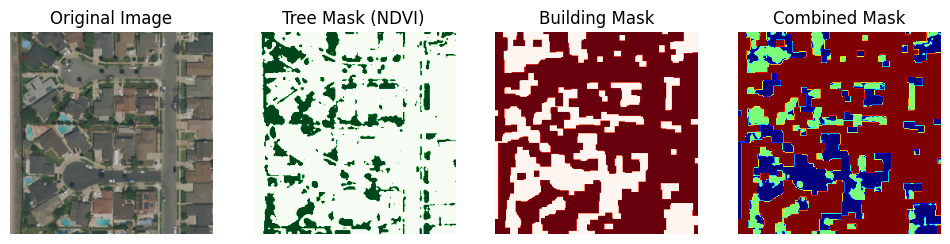

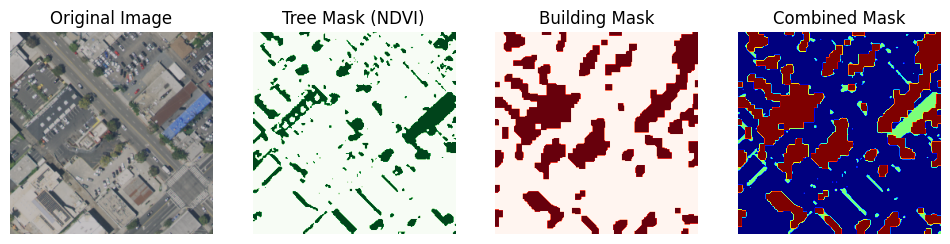

Masks generated, refined, and saved successfully!


In [5]:
num_images_displayed = 0  # Limit visualization to 5 images

for img_name in os.listdir(IMG_DIR):
    if img_name.endswith('.tif'):
        img_path = os.path.join(IMG_DIR, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if image is None:
            print(f"Failed to load image: {img_name}")
            continue

        # Resize for processing
        orig_size = image.shape[:2]
        image_resized = cv2.resize(image, (256, 256))

        # Generate masks
        ndvi = calculate_ndvi(image_resized)
        tree_mask = generate_tree_mask(ndvi)
        building_mask = detect_buildings(image_resized)

        # Combine masks
        combined_mask = generate_combined_mask(tree_mask, building_mask)

        # Resize masks to original size
        tree_mask = cv2.resize(tree_mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)
        building_mask = cv2.resize(building_mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)
        combined_mask = cv2.resize(combined_mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)

        # Save masks
        cv2.imwrite(os.path.join(TREE_MASK_DIR, img_name.replace('.tif', '_tree.tif')), tree_mask)
        cv2.imwrite(os.path.join(BUILDING_MASK_DIR, img_name.replace('.tif', '_building.tif')), building_mask)
        cv2.imwrite(os.path.join(COMBINED_MASK_DIR, img_name.replace('.tif', '_combined.tif')), combined_mask * 85)

        # Display for the first 5 images
        if num_images_displayed < 5:
            plt.figure(figsize=(12, 8))
            plt.subplot(1, 4, 1)
            plt.title("Original Image")
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.title("Tree Mask (NDVI)")
            plt.imshow(tree_mask, cmap='Greens')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.title("Building Mask")
            plt.imshow(building_mask, cmap='Reds')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.title("Combined Mask")
            plt.imshow(combined_mask, cmap='jet')
            plt.axis('off')

            plt.show()
            num_images_displayed += 1

print("Masks generated, refined, and saved successfully!")

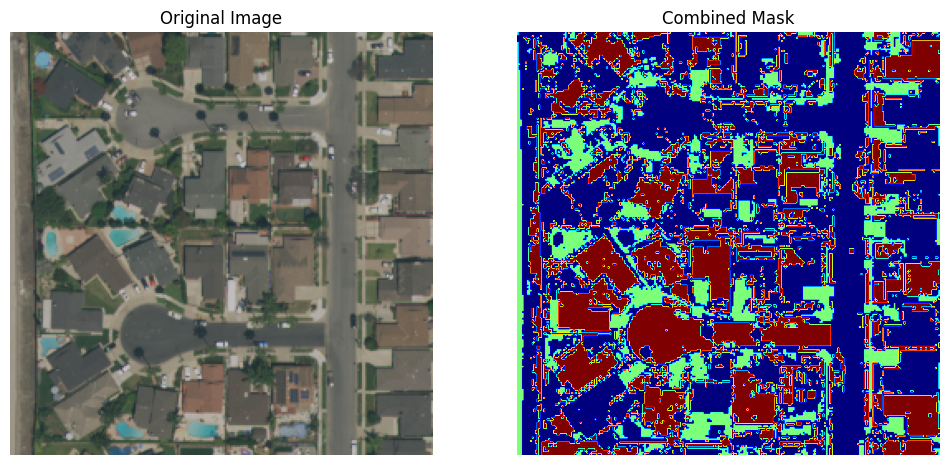

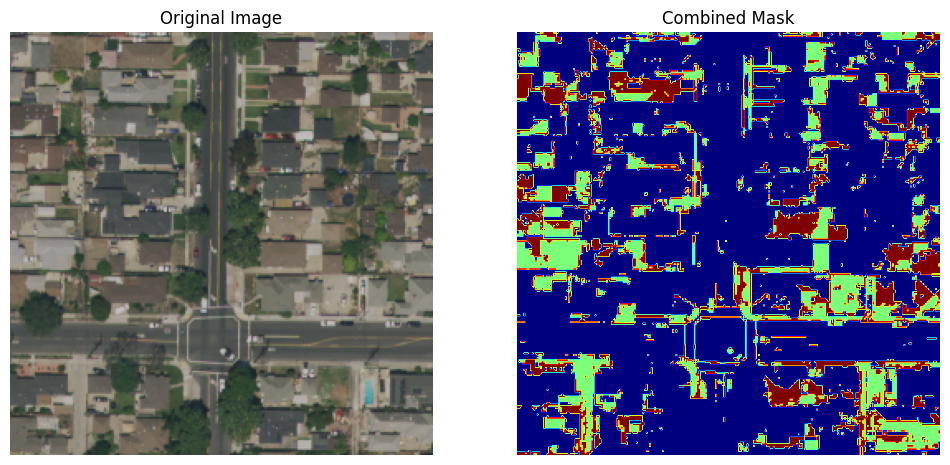

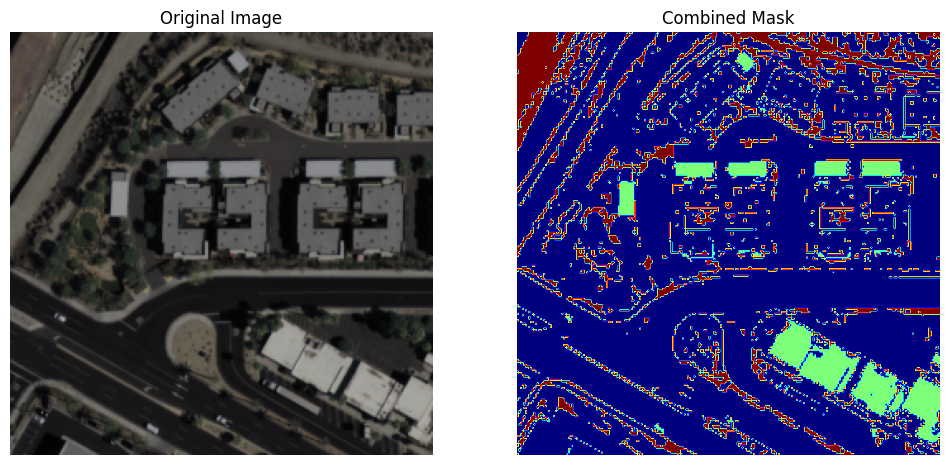

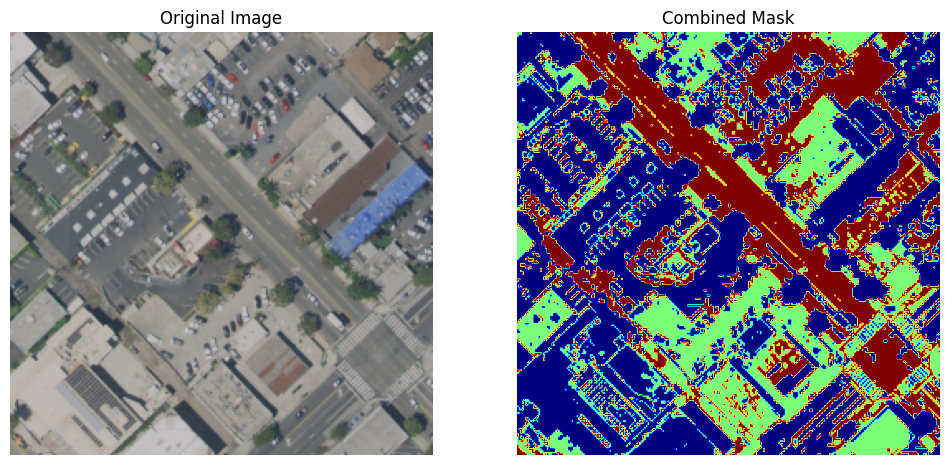

Masks generated and saved in .tif format successfully!


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define input and output directories
IMG_DIR = '/kaggle/input/datasettree/images'  # Update with your image path
MASK_OUTPUT_DIR = '/kaggle/working/ground_truth_masks/'

# Output directories for masks
TREE_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'tree_masks/')
BUILDING_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'building_masks/')
COMBINED_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'combined_masks/')

# Create directories if they don't exist
os.makedirs(TREE_MASK_DIR, exist_ok=True)
os.makedirs(BUILDING_MASK_DIR, exist_ok=True)
os.makedirs(COMBINED_MASK_DIR, exist_ok=True)

def kmeans_clustering_mask(image, k=4):
    """
    Perform K-Means clustering on the image to segment it into k regions.

    Args:
        image (np.array): Input image (RGB).
        k (int): Number of clusters for K-Means.

    Returns:
        np.array: Clustered image with clusters labeled.
        np.array: Cluster centers.
    """
    # Reshape the image to a 2D array of pixels
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixel_values)
    centers = np.uint8(kmeans.cluster_centers_)

    # Reshape labels to match the image shape
    clustered_image = labels.reshape(image.shape[:2])

    return clustered_image, centers

def generate_masks_from_clusters(clustered_image, centers):
    """
    Generate masks for trees, buildings, and background from clustered labels.

    Args:
        clustered_image (np.array): Clustered image with labels.
        centers (np.array): RGB cluster centers.

    Returns:
        tuple: Tree mask, building mask, background mask, and combined mask.
    """
    # Calculate green dominance and intensity
    green_dominance = centers[:, 1] - (centers[:, 0] + centers[:, 2]) / 2
    intensities = np.mean(centers, axis=1)

    # Assign clusters
    background_label = np.argmin(intensities)  # Lowest intensity -> background
    tree_label = np.argmax(green_dominance)    # Highest green dominance -> trees
    remaining_labels = list(set(range(len(centers))) - {background_label, tree_label})
    building_label = remaining_labels[0]       # Remaining cluster -> buildings

    # Generate masks
    background_mask = np.uint8(clustered_image == background_label) * 255
    tree_mask = np.uint8(clustered_image == tree_label) * 255
    building_mask = np.uint8(clustered_image == building_label) * 255

    # Combined mask: Trees = 1, Buildings = 2, Background = 0
    combined_mask = np.zeros_like(clustered_image, dtype=np.uint8)
    combined_mask[clustered_image == tree_label] = 1
    combined_mask[clustered_image == building_label] = 2

    return tree_mask, building_mask, background_mask, combined_mask

# Process all .tif images
num_images_displayed = 0
for img_name in os.listdir(IMG_DIR):
    if img_name.endswith('.tif'):
        img_path = os.path.join(IMG_DIR, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if image is None:
            print(f"Failed to load image: {img_name}")
            continue

        # Resize to (256, 256)
        image_resized = cv2.resize(image, (256, 256))

        # Perform K-Means clustering with k=5
        clustered_image, centers = kmeans_clustering_mask(image_resized, k=5)

        # Generate masks
        tree_mask, building_mask, background_mask, combined_mask = generate_masks_from_clusters(clustered_image, centers)

        # Save masks in .tif format
        tree_mask_path = os.path.join(TREE_MASK_DIR, img_name.replace('.tif', '_tree.tif'))
        building_mask_path = os.path.join(BUILDING_MASK_DIR, img_name.replace('.tif', '_building.tif'))
        combined_mask_path = os.path.join(COMBINED_MASK_DIR, img_name.replace('.tif', '_combined.tif'))

        cv2.imwrite(tree_mask_path, tree_mask)
        cv2.imwrite(building_mask_path, building_mask)
        cv2.imwrite(combined_mask_path, combined_mask * 127)  # Scale combined mask for visibility

        # Visualize the combined mask for the first 5 images
        if num_images_displayed < 5:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Combined Mask")
            plt.imshow(combined_mask, cmap='jet')  # 0=background, 1=tree, 2=building
            plt.axis('off')

            plt.show()

            num_images_displayed += 1

print("Masks generated and saved in .tif format successfully!")


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define dataset paths
image_dir = '/kaggle/input/datasettree/images/'  # Directory containing input images
mask_dir = '/kaggle/working/ground_truth_masks/combined_masks/'  # Directory containing generated masks
output_dir = '/kaggle/working/split_dataset/'  # Directory to save split data

# Create output directories for images and masks in train, val, and test
for split_dir in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split_dir, 'masks'), exist_ok=True)

# List all image files and corresponding mask files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
mask_files = [f.replace('.tif', '_combined.tif') for f in image_files]

# Pair valid image and mask paths
valid_pairs = [(os.path.join(image_dir, img), os.path.join(mask_dir, mask))
               for img, mask in zip(image_files, mask_files) if os.path.exists(os.path.join(mask_dir, mask))]

# Raise an error if no valid pairs are found
if not valid_pairs:
    raise FileNotFoundError("No valid image-mask pairs found. Check your dataset paths and naming conventions.")

# Split data into train, validation, and test sets
train_pairs, temp_pairs = train_test_split(valid_pairs, test_size=0.3, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

# Function to copy image and mask files to their respective directories
def copy_files(pairs, split_dir):
    for img_path, mask_path in pairs:
        shutil.copy(img_path, os.path.join(output_dir, split_dir, 'images', os.path.basename(img_path)))
        shutil.copy(mask_path, os.path.join(output_dir, split_dir, 'masks', os.path.basename(mask_path)))

# Execute copying of files
copy_files(train_pairs, 'train')
copy_files(val_pairs, 'val')
copy_files(test_pairs, 'test')

# Print summary of data split
print("Data split and saved successfully!")
print(f"Training Data: {len(train_pairs)} pairs")
print(f"Validation Data: {len(val_pairs)} pairs")
print(f"Test Data: {len(test_pairs)} pairs")


Data split and saved successfully!
Training Data: 1155 pairs
Validation Data: 248 pairs
Test Data: 248 pairs


In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# Function to load and preprocess images and masks
def load_data(image_dir, mask_dir, img_size=(256, 256), num_classes=3):
    images, masks = [], []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name.replace('.tif', '_combined.tif'))  # Match naming convention
        
        # Read and preprocess image
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size) / 255.0  # Normalize image
        
        # Read and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        
        # Remap mask values to [0, 1, 2]
        mask_cleaned = np.zeros_like(mask)
        mask_cleaned[mask == 0] = 0         # Background
        mask_cleaned[mask == 127] = 1       # Trees
        mask_cleaned[mask == 254] = 2       # Buildings (changed from 255 to 254)
        
        images.append(image)
        masks.append(mask_cleaned)
    
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.int32)
    masks = tf.keras.utils.to_categorical(masks, num_classes=num_classes)  # One-hot encode masks
    return images, masks

# Define paths to dataset
train_image_dir = '/kaggle/working/split_dataset/train/images/'
train_mask_dir = '/kaggle/working/split_dataset/train/masks/'
val_image_dir = '/kaggle/working/split_dataset/val/images/'
val_mask_dir = '/kaggle/working/split_dataset/val/masks/'

# Load train and validation datasets
IMG_SIZE = (256, 256)
NUM_CLASSES = 3
X_train, Y_train = load_data(train_image_dir, train_mask_dir, IMG_SIZE, NUM_CLASSES)
X_val, Y_val = load_data(val_image_dir, val_mask_dir, IMG_SIZE, NUM_CLASSES)

print(f"Training Data: {X_train.shape}, {Y_train.shape}")
print(f"Validation Data: {X_val.shape}, {Y_val.shape}")

Training Data: (1155, 256, 256, 3), (1155, 256, 256, 3)
Validation Data: (248, 256, 256, 3), (248, 256, 256, 3)


In [9]:
def unet_model(input_shape=(256, 256, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottom
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c5)
    u1 = layers.Conv2D(512, (2, 2), activation='relu', padding='same')(u1)
    u1 = layers.concatenate([u1, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u2 = layers.UpSampling2D((2, 2))(c6)
    u2 = layers.Conv2D(256, (2, 2), activation='relu', padding='same')(u2)
    u2 = layers.concatenate([u2, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u3 = layers.UpSampling2D((2, 2))(c7)
    u3 = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(u3)
    u3 = layers.concatenate([u3, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u4 = layers.UpSampling2D((2, 2))(c8)
    u4 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(u4)
    u4 = layers.concatenate([u4, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Final layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
# Instantiate the U-Net model
unet = unet_model(input_shape=(256, 256, 3), num_classes=NUM_CLASSES)

# Compile the model
unet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class segmentation
    metrics=['accuracy']
)

# Print model summary
unet.summary()

# Train the model
history_unet = unet.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,  # Adjust based on your requirements
    batch_size=16,
    verbose=1
)

# Save the trained model
unet.save('/kaggle/working/unet_model.h5')
print("Model saved successfully!")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │  2,097,664 │ up_sampling2d[0]

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1735820373.791569     103 service.cc:145] XLA service 0x7a18740033f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735820373.791634     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1735820412.674574     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 ━━━━━━━━━━━━━━━━━━━━ 99s 754ms/step - accuracy: 0.6199 - loss: 5.0159 - val_accuracy: 0.6386 - val_loss: 0.8762
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6180 - loss: 0.8578 - val_accuracy: 0.6225 - val_loss: 0.8177
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6258 - loss: 0.8160 - val_accuracy: 0.6371 - val_loss: 0.8095
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6250 - loss: 0.8150 - val_accuracy: 0.6304 - val_loss: 0.8058
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6356 - loss: 0.8110 - val_accuracy: 0.6425 - val_loss: 0.7990
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6280 - loss: 0.8142 - val_accuracy: 0.6460 - val_loss: 0.8107
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6380 - loss: 0.7871 - val_accuracy: 0.6468 - val_loss: 0.7829
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6394 - loss: 0.7899 - val_accuracy: 0.632

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_unet.history['loss'], label='Training Loss')
plt.plot(history_unet.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_unet.history['accuracy'], label='Training Accuracy')
plt.plot(history_unet.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Accuracy Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [19]:
# Load test data
test_image_dir = '/kaggle/working/split_dataset/test/images/'
test_mask_dir = '/kaggle/working/split_dataset/test/masks/'

# Load the test dataset
X_test, Y_test = load_data(test_image_dir, test_mask_dir, IMG_SIZE, NUM_CLASSES)

# Evaluate on validation set
val_loss, val_accuracy = unet.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Evaluate on test set
test_loss, test_accuracy = unet.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.6707 - loss: 0.7367 
Validation Loss: 0.7538436651229858, Validation Accuracy: 0.6646543145179749
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.6493 - loss: 0.7488
Test Loss: 0.743897557258606, Test Accuracy: 0.6531846523284912


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import numpy as np

# Predict on the test set
y_pred = unet.predict(X_test)  # Predict the masks for the test set
y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert softmax predictions to class indices
y_true_classes = np.argmax(Y_test, axis=-1)  # Convert one-hot encoded ground truth to class indices

# Flatten predictions and ground truth for pixel-wise comparison
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

def dice_coefficient(y_true, y_pred, num_classes):
    dice_scores = []
    for class_id in range(num_classes):
        y_true_binary = (y_true == class_id).astype(int)
        y_pred_binary = (y_pred == class_id).astype(int)
        intersection = np.sum(y_true_binary * y_pred_binary)
        dice = (2.0 * intersection) / (np.sum(y_true_binary) + np.sum(y_pred_binary) + 1e-7)
        dice_scores.append(dice)
    return dice_scores


# Compute metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=1)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=1)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=1)
iou = jaccard_score(y_true_flat, y_pred_flat, average='weighted')
dice_scores = dice_coefficient(y_true_flat, y_pred_flat, NUM_CLASSES)

# Print metrics
print(f"U-Net Evaluation Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")
for class_id, dice in enumerate(dice_scores):
    print(f"Dice Coefficient for Class {class_id}: {dice:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step
U-Net Evaluation Metrics
Accuracy: 0.6532
Precision: 0.7321
Recall: 0.6532
F1 Score: 0.5581
IoU: 0.4449
Dice Coefficient for Class 0: 0.7765
Dice Coefficient for Class 1: 0.5401
Dice Coefficient for Class 2: 0.0000


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true_flat, y_pred_flat))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.66      0.95      0.78   9898047
           1       0.63      0.47      0.54   2565250
           2       0.00      0.00      0.00   3789631

    accuracy                           0.65  16252928
   macro avg       0.43      0.47      0.44  16252928
weighted avg       0.50      0.65      0.56  16252928



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step


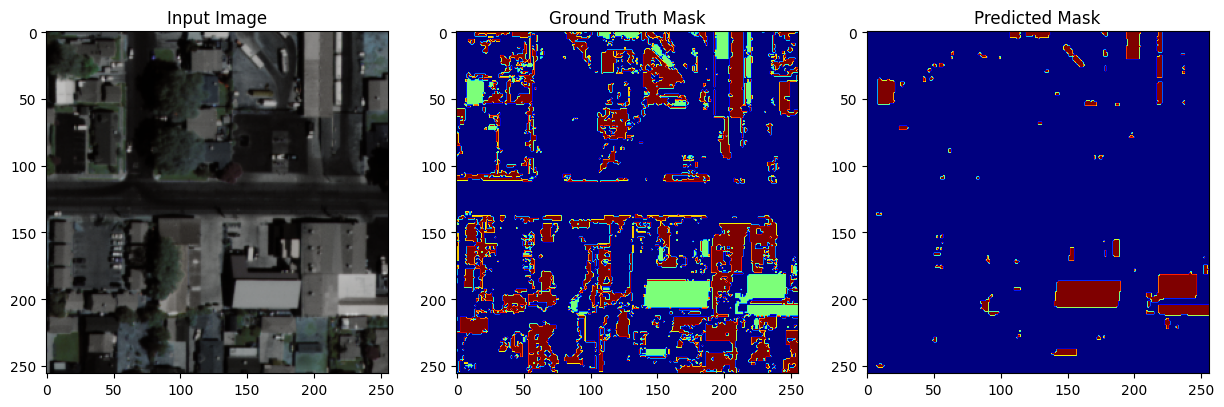

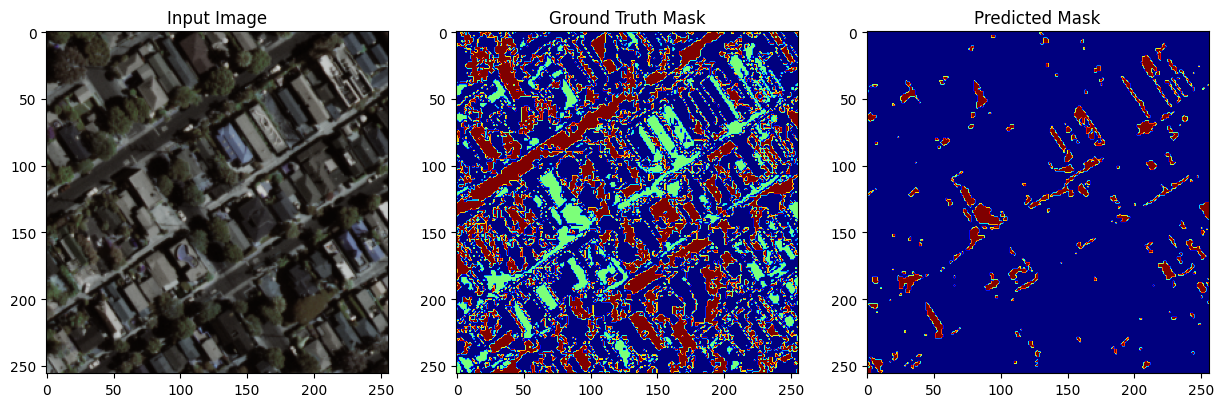

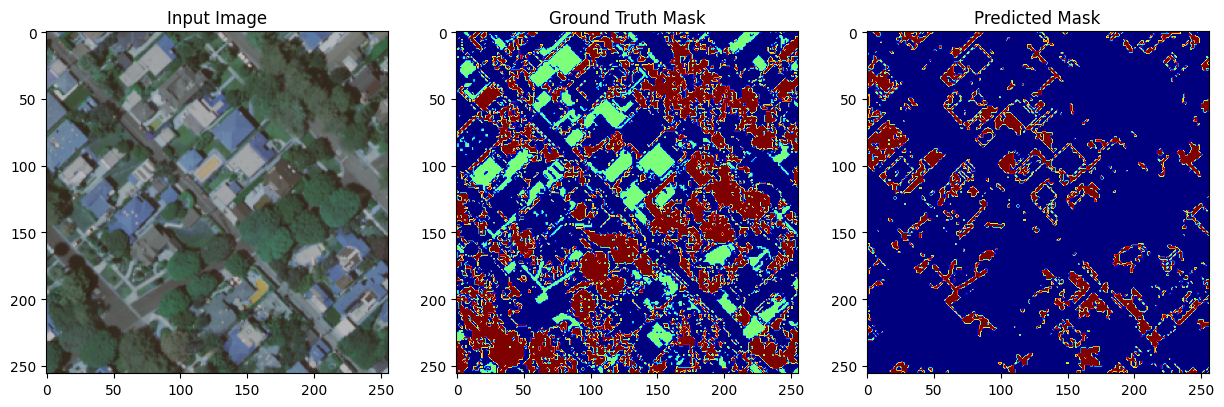

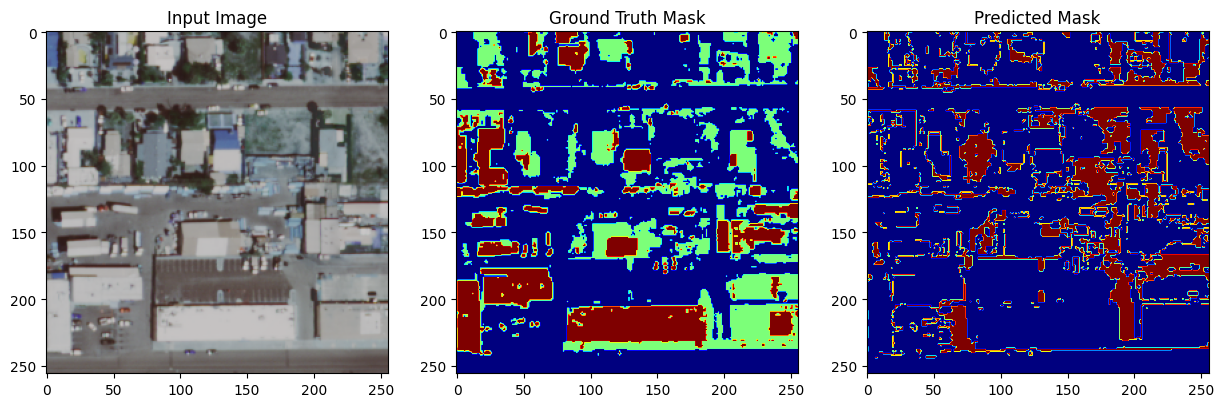

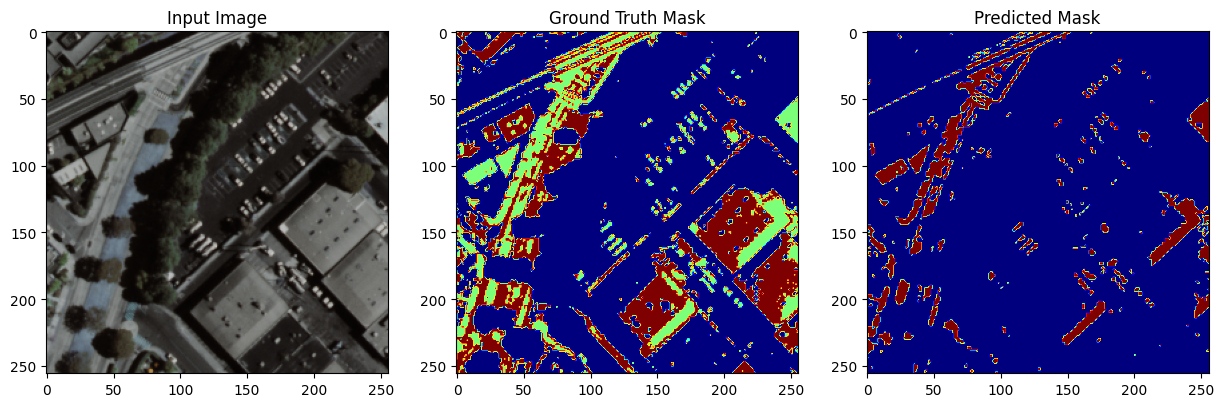

In [21]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = unet.predict(X_test)

# Visualize one prediction
def visualize_prediction(index):
    """
    Visualize the input image, ground truth mask, and predicted mask.
    Args:
        index (int): Index of the image in the test set.
    """
    plt.figure(figsize=(15, 5))

    # Input Image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X_test[index])

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(np.argmax(Y_test[index], axis=-1), cmap='jet')  # Convert one-hot to class index

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(np.argmax(predictions[index], axis=-1), cmap='jet')

    plt.show()

# Visualize predictions for the first 5 test images
for i in range(5):
    visualize_prediction(i)


In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def segnet_model(input_shape=(256, 256, 3), num_classes=3):
    # Encoder
    inputs = layers.Input(shape=input_shape)
    
    # Encoder Block 1
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Encoder Block 2
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Encoder Block 3
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Encoder Block 4
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Decoder Block 4
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Decoder Block 3
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Decoder Block 2
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Decoder Block 1
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Final classification layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def train_segnet_model(X_train, Y_train, X_val, Y_val, num_classes=3):
    # Create SegNet model
    segnet_model_instance = segnet_model(
        input_shape=X_train.shape[1:], 
        num_classes=num_classes
    )
    
    # Compile the model
    segnet_model_instance.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        '/kaggle/working/segnet_best_model.keras',  # Updated to .keras format
        monitor='val_loss', 
        save_best_only=True, 
        mode='min'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6
    )
    
    # Train the model
    history = segnet_model_instance.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=50,
        batch_size=16,
        callbacks=[checkpoint, early_stopping, lr_reducer],
        verbose=1
    )
    
    # Save final model
    segnet_model_instance.save('/kaggle/working/segnet_final_model.keras')  # Updated to .keras format
    
    return segnet_model_instance, history


# Evaluation function
def evaluate_segnet_model(model, X_test, Y_test):
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Predict on test data
    predictions = model.predict(X_test)
    
    return predictions, test_loss, test_accuracy

# Main execution
if __name__ == "__main__":
    # Assuming X_train, Y_train, X_val, Y_val are already prepared
    segnet_model_instance, history = train_segnet_model(X_train, Y_train, X_val, Y_val)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 37s 318ms/step - accuracy: 0.5166 - loss: 1.0606 - val_accuracy: 0.2355 - val_loss: 1.0980 - learning_rate: 1.0000e-04
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.6334 - loss: 0.8595 - val_accuracy: 0.6241 - val_loss: 0.9770 - learning_rate: 1.0000e-04
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.6335 - loss: 0.8473 - val_accuracy: 0.6240 - val_loss: 0.9996 - learning_rate: 1.0000e-04
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.6378 - loss: 0.8301 - val_accuracy: 0.6236 - val_loss: 0.9384 - learning_rate: 1.0000e-04
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.6427 - loss: 0.8216 - val_accuracy: 0.6229 - val_loss: 0.9390 - learning_rate: 1.0000e-04
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.6450 - loss: 0.8134 - val_accuracy: 0.6242 - val_loss: 0.9319 - learning_rate: 1.0000e-04
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - acc

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import numpy as np
# Evaluate on test data
predictions, test_loss, test_accuracy = evaluate_segnet_model(segnet_model_instance, X_test, Y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict on test data
y_pred_seg = segnet_model_instance.predict(X_test)
y_pred_classes_seg = np.argmax(y_pred_seg, axis=-1)  # Convert softmax to class indices
y_true_classes = np.argmax(Y_test, axis=-1)  # Convert one-hot encoded ground truth to class indices


# Flatten predictions and ground truth for pixel-wise comparison
y_pred_flat_seg = y_pred_classes_seg.flatten()
y_true_flat = y_true_classes.flatten()

def dice_coefficient(y_true, y_pred_seg, num_classes):
    dice_scores = []
    for class_id in range(num_classes):
        y_true_binary = (y_true == class_id).astype(int)
        y_pred_binary_seg = (y_pred_seg == class_id).astype(int)
        intersection = np.sum(y_true_binary * y_pred_binary_seg)
        dice = (2.0 * intersection) / (np.sum(y_true_binary) + np.sum(y_pred_binary_seg) + 1e-7)
        dice_scores.append(dice)
    return dice_scores


# Compute metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat_seg, average='weighted', zero_division=1)
recall = recall_score(y_true_flat, y_pred_flat_seg, average='weighted', zero_division=1)
f1 = f1_score(y_true_flat, y_pred_flat_seg, average='weighted', zero_division=1)
iou = jaccard_score(y_true_flat, y_pred_flat_seg, average='weighted')
dice_scores = dice_coefficient(y_true_flat, y_pred_flat_seg, NUM_CLASSES)

# Print metrics
print(f"Seg-Net Evaluation Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")
for class_id, dice in enumerate(dice_scores):
    print(f"Dice Coefficient for Class {class_id}: {dice:.4f}")

Test Loss: 0.8014
Test Accuracy: 0.6352
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Test Loss: 0.8014, Test Accuracy: 0.6352
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Seg-Net Evaluation Metrics
Accuracy: 0.6532
Precision: 0.5755
Recall: 0.6352
F1 Score: 0.5451
IoU: 0.4273
Dice Coefficient for Class 0: 0.7671
Dice Coefficient for Class 1: 0.4302
Dice Coefficient for Class 2: 0.0432


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true_flat, y_pred_flat_seg))

              precision    recall  f1-score   support

           0       0.65      0.95      0.77   9898047
           1       0.57      0.34      0.43   2565250
           2       0.39      0.02      0.04   3789631

    accuracy                           0.64  16252928
   macro avg       0.54      0.44      0.41  16252928
weighted avg       0.58      0.64      0.55  16252928



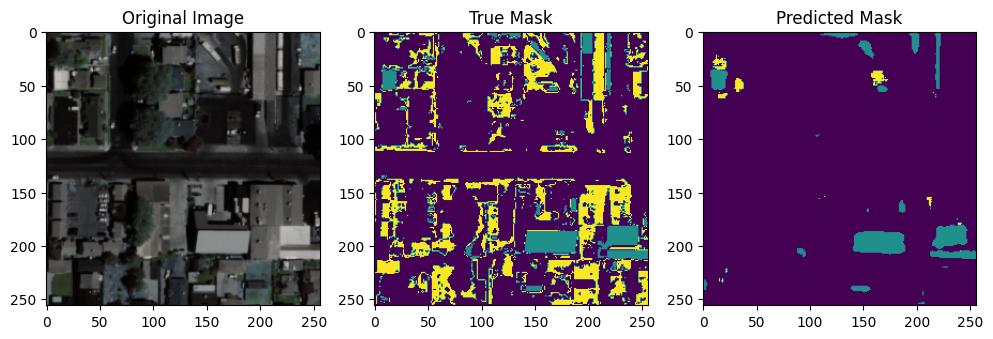

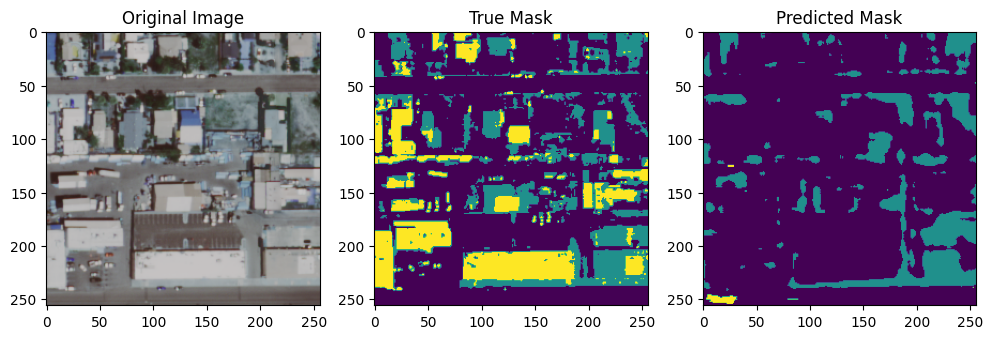

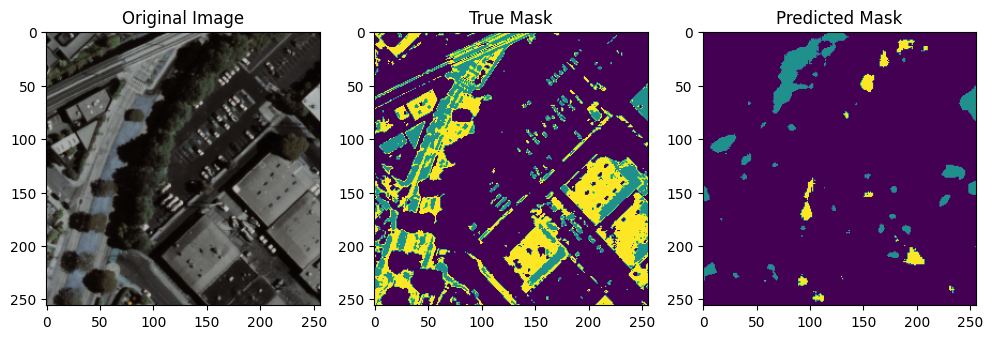

In [32]:
# Visualize test predictions
import matplotlib.pyplot as plt
predicted_masks = np.argmax(predictions, axis=-1)  # Convert one-hot encoded predictions to class labels
true_masks = np.argmax(Y_test, axis=-1)

for i in range(5):  # Display 3 samples
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title("Original Image")
    
    # True mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_masks[i])
    plt.title("True Mask")
    
    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i])
    plt.title("Predicted Mask")
    
    plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def build_mask_rcnn(input_shape=(256, 256, 3), num_classes=3):
    """
    Build a simplified Mask R-CNN model for segmentation.
    """
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Mask Head
    mask_output = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=mask_output)
    return model

# Instantiate the model
mask_rcnn_model = build_mask_rcnn(input_shape=(256, 256, 3), num_classes=3)
mask_rcnn_model.summary()


In [ ]:
# Compile the model
mask_rcnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Suitable for multi-class segmentation
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(
    "mask_rcnn_best_model.keras",  # Updated to .keras format
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = mask_rcnn_model.fit(
    X_train, Y_train,  # Training data
    validation_data=(X_val, Y_val),  # Validation data
    epochs=60,  # Number of epochs
    batch_size=16,  # Adjust based on GPU memory
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model
test_loss, test_accuracy = mask_rcnn_model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}")


In [ ]:
# Import libraries
from matplotlib import colors

# Define a color map for the classes
cmap = colors.ListedColormap(['black', 'green', 'blue'])  # Adjust colors as needed
bounds = [-0.5, 0.5, 1.5, 2.5]  # Define boundaries for 3 classes
norm = colors.BoundaryNorm(bounds, cmap.N)

# Loop through the first 5 images in the validation set
num_images = 5
plt.figure(figsize=(15, num_images * 5))
for i in range(num_images):
    # Select the image, ground truth mask, and predicted mask
    test_image = X_val[i]
    test_mask = np.argmax(Y_val[i], axis=-1)  # Convert one-hot to class indices
    predicted_mask = np.argmax(mask_rcnn_model.predict(test_image[np.newaxis, ...])[0], axis=-1)

    # Display Original Image
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(test_image)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Display Ground Truth Mask
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(test_mask, cmap=cmap, norm=norm)
    plt.title(f"Ground Truth Mask {i+1}")
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=[0, 1, 2])
    plt.axis('off')

    # Display Predicted Mask
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    plt.title(f"Predicted Mask {i+1}")
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=[0, 1, 2])
    plt.axis('off')

plt.tight_layout()
plt.show()
